<a href="https://colab.research.google.com/github/sebinefrancis/Deep-Learning-Exercise/blob/Housing_Price_Regression/Housing_Price_Regression/House_Price_Prediction_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the Boston housing dataset

In [2]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
print('Shape of training dataset : ',train_data.shape)
print('Shape of test dataset : ',test_data.shape)

Using TensorFlow backend.


57344/57026 [==============================] - 0s 1us/step
Shape of training dataset :  (404, 13)
Shape of test dataset :  (102, 13)


The targets are the median values of owner-occupied homes, in thousands of
dollars

**Preparing the data**

Normalizing the data

feature-wise normalization: for each feature in the input
data (a column in the input data matrix), you subtract the mean of the feature and
divide by the standard deviation, so that the feature is centered around 0 and has a
unit standard deviation.

In [0]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

Note that the quantities used for normalizing the test data are computed using the
training data. You should never use in your workflow any quantity computed on the
test data, even for something as simple as data normalization.

**Building your network**

Because so few samples are available, you’ll use a very small network with two hidden
layers, each with 64 units. In general, the less training data you have, the worse overfitting
will be, and using a small network is one way to mitigate overfitting.

In [0]:
from keras import models
from keras import layers
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
    input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

**Validating your approach using K-fold validation**



In [5]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
                            [train_data[:i * num_val_samples],
                            train_data[(i + 1) * num_val_samples:]],
                            axis=0)
    partial_train_targets = np.concatenate(
                            [train_targets[:i * num_val_samples],
                            train_targets[(i + 1) * num_val_samples:]],
                            axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

print('Final epoch mae value in each folds: ',all_scores)
print('Mean value of mae among 4 folds: ',np.mean(all_scores))

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Final epoch mae value in each folds:  [2.2136588096618652, 2.5543034076690674, 2.871403217315674, 2.4132447242736816]
Mean value of mae among 4 folds:  2.513152539730072


The different runs do indeed show rather different validation scores, from 2.6 to 3.2.
The average (3.0) is a much more reliable metric than any single score—that’s the
entire point of K-fold cross-validation. In this case, you are off by 3,000  on average,
which is significant considering that the prices range from $10,000 to 50,000.
Let’s try training the network a bit longer: 500 epochs

**Saving the validation logs at each fold**

Here we calculate the average of mae values of 4 folds at every epochs to plot epochs against avg mae value at each epoch

In [6]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
                        [train_data[:i * num_val_samples],
                        train_data[(i + 1) * num_val_samples:]],
                        axis=0)
    partial_train_targets = np.concatenate(
                        [train_targets[:i * num_val_samples],
                        train_targets[(i + 1) * num_val_samples:]],
                        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


**Building the history of successive mean K-fold validation scores**

In [15]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)] #this outputs a list, not tensor/array prints as comma separated
#all_mae_histories contains 4 arrays corresponding to each fold
#each of the 4 arrays contains 500 values which are mae corresponding to each epoch
#so here we iterate first over number of epochs, so i th epoch
#then iterate over each of 4 array in all_mae_histories which are arrays containing 500 vals each
# so we take i th epoch value of first fold, second fold, third and fourth and do mean
# so we got average mae of ith epoch
# similarly we get 500 average mae values, each corresponding to each epoch


#Is the following a simple code , but do the same??

average_mae_history2 = np.mean(all_mae_histories,axis=0) #this gives a numpy tensor/array, prints as space separated
print( np.array(average_mae_history2[:10]))
print(np.array(average_mae_history[:10]))

[4.38443375 3.20155215 2.89642096 2.83466339 2.82249975 2.6906988
 2.67871147 2.60277212 2.6011712  2.50517559]
[4.38443375 3.20155215 2.89642096 2.83466339 2.82249975 2.6906988
 2.67871147 2.60277212 2.6011712  2.50517559]


**Plotting validation scores**

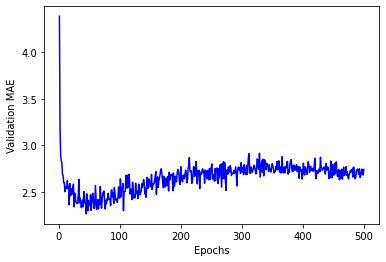

In [26]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history,'b')
#plt.plot(range(1, len(average_mae_history) + 1), average_mae_history2,'ro')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

**Plotting validation scores, excluding the first 10 data points**

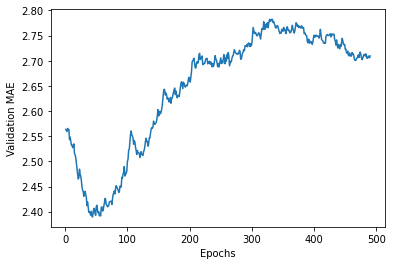

In [18]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

**Training the final model**

In [38]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print('Final Result : ',test_mae_score)

102/102 [==============================] - 0s 147us/step
Final Result :  2.5932776927948
